<a href="https://colab.research.google.com/github/ndamulelonemakh/shared-notebooks/blob/main/1_0_nn_zabantu_POS_share001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

## Fine-tune a [ZaBantu](https://huggingface.co/dsfsi/zabantu-xlm-roberta) model on a Parts of Speech(POS) task

This notebook demonstrates how to use the 🤗 Transformers library to **fine-tune a pre-trained language model** on a token classification task(this can either be `pos` or `ner`)

The notebook is divided into the following sections:

* **Environment Setup**
* **Global Parameters**
* **Data Preparation**
* **Preprocessing the data**
* **Fine-tuning the Pre-Trained Model**
* **Evaluate the Fine-Tuned Model**
* **(Optional) Upload to hub**

> This notebook is intended for users who are familiar with the basics of deep learning and natural language processing. It is also recommended that users have some experience with the Python programming language and the Jupyter Notebook environment.


---

* [Reference - Huggingface Notebook Examples on GitHub](https://github.com/huggingface/notebooks)

# Environment setup

**Make sure to install the dependencies below if you have not done so already**

In [60]:
%pip install --quiet datasets transformers sentencepiece seqeval

In [61]:
%pip install accelerate -U --quiet

In [62]:
%pip install --quiet --upgrade huggingface_hub

In [63]:
%pip install --quiet evaluate

In [64]:
import transformers

print(transformers.__version__)

4.40.1


**If you intend to upload your trained model to HuggingFace or access a private model: ***

* You need to login, using any of the recommended [authentication methods](https://huggingface.co/docs/huggingface_hub/en/quick-start#authentication)
* In this notebook we use `huggingface_hub.notebook_login()` method

In [65]:
from huggingface_hub import notebook_login, whoami

try:
  whoami()
except:
  print("User token not found, calling notebook_login()...")
  notebook_login()

# Global Parameters

In [100]:
task = "pos" # Can be one of "pos" or "ner"

# model options:
# - dsfsi/zabantu-xlm-roberta
# - dsfsi/zabantu-sot-ven-170m
# - dsfsi/zabantu-nso-ven-170m
# - dsfsi/zabantu-nso-120m
model_checkpoint = "dsfsi/zabantu-sot-ven-170m"
dataset_checkpoint = "conll2003"
push_to_hub_enabled = False
trained_model_checkpoint = f"{model_checkpoint}-finetuned-{task}"
trained_model_checkpoint_hub = f"ndamulelonemakh/{trained_model_checkpoint}"
batch_size = 16  # adjust depending on GPU size
epochs = 3

# Data Preperation

- Once processed, your dataset must look somthing like this:


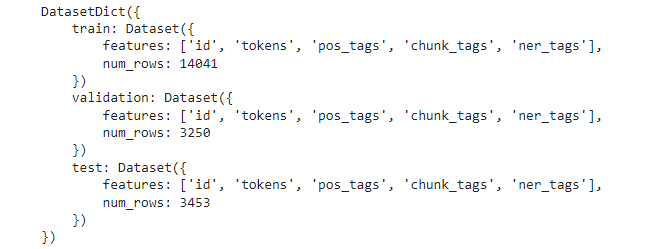

## Load Masakhane POS

### Utilities

In [67]:
from datasets import load_dataset, Dataset, DatasetDict
from typing import List, Tuple


def load_sentences(filepath: str) -> List[List[Tuple[str, str]]]:
    """
    Load sentences from a file in IOB format.

    Args:
        filepath (str): Path to the input file.

    Returns:
        List[List[Tuple[str, str]]]: A list of sentences, where each sentence is a list of tuples (token, pos_tag).
    """
    sentences = []
    current_sentence = []

    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            if len(line.strip()) == 0:
                sentences.append(current_sentence)
                current_sentence = []
            else:
                token, pos_tag = line.strip().split()
                current_sentence.append((token, pos_tag))

    if current_sentence:
        sentences.append(current_sentence)

    return sentences


def convert_to_conll(sentences: List[List[Tuple[str, str]]]) -> List[dict]:
    """
    Convert sentences to the CoNLL-3 format.

    Args:
        sentences (List[List[Tuple[str, str]]]): A list of sentences, where each sentence is a list of tuples (token, pos_tag).

    Returns:
        List[dict]: A list of dictionaries representing the sentences in the CoNLL-3 format.
    """
    data = []

    for sent_id, sentence in enumerate(sentences):
        tokens = []
        pos_tags = []
        for token, pos_tag in sentence:
            tokens.append(token)
            pos_tags.append(pos_tag)

        data.append({
            "id": sent_id,
            "tokens": tokens,
            "pos_tags": pos_tags,
        })

    return data


def create_hf_dataset(data: List[dict]) -> Dataset:
    """
    Convert data to a Hugging Face Dataset.

    Args:
        data (List[dict]): A list of dictionaries representing the sentences in the CoNLL-3 format.

    Returns:
        Dataset: A Hugging Face Dataset containing the data.
    """
    from datasets import Dataset, ClassLabel, Sequence

    pos_tag_class = ClassLabel(names=sorted(set(tag for d in data for tag in d["pos_tags"])))

    encoded_data = {
        "id": [],
        "tokens": [],
        "pos_tags": [],
    }

    for d in data:
        encoded_pos_tags = pos_tag_class.str2int(d["pos_tags"])
        encoded_data['id'].append(d['id'])
        encoded_data['tokens'].append(d['tokens'])
        encoded_data['pos_tags'].append(encoded_pos_tags)

    d = Dataset.from_dict(encoded_data)
    pos_tags_feature = Sequence(feature=ClassLabel(names=pos_tag_class.names))
    d = d.cast_column('pos_tags', pos_tags_feature)

    return d


def iob_to_hugging_face(train_file: str, validation_file: str = None, test_file: str = None) -> DatasetDict:
    sentences = load_sentences(train_file)
    sentence_dicts = convert_to_conll(sentences)
    train_dataset = create_hf_dataset(sentence_dicts)

    data_dict = DatasetDict({'train': train_dataset})

    # If validation_file is provided, load and convert the sentences
    if validation_file:
        validation_sentences = load_sentences(validation_file)
        validation_sentence_dicts = convert_to_conll(validation_sentences)
        validation_dataset = create_hf_dataset(validation_sentence_dicts)
        data_dict['validation'] = validation_dataset

    # If test_file is provided, load and convert the sentences
    if test_file:
        test_sentences = load_sentences(test_file)
        test_sentence_dicts = convert_to_conll(test_sentences)
        test_dataset = create_hf_dataset(test_sentence_dicts)
        data_dict['test'] = test_dataset
    return data_dict


In [68]:
from datasets import ClassLabel, Sequence
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
        elif isinstance(typ, Sequence) and isinstance(typ.feature, ClassLabel):
            df[column] = df[column].transform(lambda x: [typ.feature.names[i] for i in x])
    display(HTML(df.to_html()))

### Format Masakhane as Huggingface Dataset

In [69]:
## Get masakhane POS dataset
!wget https://raw.githubusercontent.com/masakhane-io/masakhane-pos/main/data/tsn/train.txt
!wget https://raw.githubusercontent.com/masakhane-io/masakhane-pos/main/data/tsn/dev.txt
!wget https://raw.githubusercontent.com/masakhane-io/masakhane-pos/main/data/tsn/test.txt

--2024-05-02 08:53:23--  https://raw.githubusercontent.com/masakhane-io/masakhane-pos/main/data/tsn/train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 219713 (215K) [text/plain]
Saving to: ‘train.txt.1’

train.txt.1         100%[===================>] 214.56K  --.-KB/s    in 0.009s  

2024-05-02 08:53:24 (24.4 MB/s) - ‘train.txt.1’ saved [219713/219713]

--2024-05-02 08:53:24--  https://raw.githubusercontent.com/masakhane-io/masakhane-pos/main/data/tsn/dev.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40665 (40K) [text

In [70]:
datasets = iob_to_hugging_face('train.txt', 'dev.txt', 'test.txt')

Casting the dataset:   0%|          | 0/754 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/150 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/602 [00:00<?, ? examples/s]

In [71]:
datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags'],
        num_rows: 754
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags'],
        num_rows: 150
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags'],
        num_rows: 602
    })
})

In [72]:
show_random_elements(datasets["train"])

,id,tokens,pos_tags
0,654,"[ka, gale, ,, go, begilwe, gore, leroborobo, la, corona, le, tshwerwe, madirelo, a, mantsi, a, sa, nagana, ,, mme, se, sa, pateletsa, gore, bao, ba, leng, mo, karolong, ya, botlhami, ba, dire, dilo, ka, tsela, e, nngwe]","[ADP, ADV, PUNCT, VERB, VERB, CCONJ, NOUN, DET, NOUN, CCONJ, VERB, NOUN, DET, ADJ, DET, AUX, VERB, PUNCT, CCONJ, DET, AUX, VERB, CCONJ, DET, DET, AUX, DET, NOUN, DET, NOUN, PRON, VERB, NOUN, ADP, NOUN, DET, DET]"
1,114,"[Jaaka, a, itse, ke, balatsedi, ba, gagwe, ka, leina, go, diragatsa, la, DMX, kgotsa, Dark, Man, X, ,, Simmons, o, begilwe, a, beilwe, mo, motšheneng, wa, tshegetso, botshelong, ka, Mosupologo, ,, go, ya, ka, RollingStone, .]","[CCONJ, DET, VERB, ADP, NOUN, DET, DET, ADP, NOUN, VERB, VERB, DET, PROPN, CCONJ, PROPN, PROPN, PROPN, PUNCT, PROPN, DET, VERB, DET, VERB, DET, NOUN, DET, NOUN, NOUN, ADP, NOUN, PUNCT, DET, ADV, ADP, PROPN, PUNCT]"
2,25,"[O, tla, dira, pontsho, ya, bobedi, ka, 9, Motsheganong, ,, e, leng, letsatsi, la, bomme, kwa, United, State, .]","[PRON, VERB, VERB, NOUN, DET, NUM, ADP, NUM, NOUN, PUNCT, DET, AUX, NOUN, DET, NOUN, DET, PROPN, PROPN, PUNCT]"
3,281,"[O, okeditse, ka, gore, ,, tsweletso, go, tswa, go, lebante, la, letsogo, la, ga, Ronaldo, e, ka, nna, seabe, se, se, botlhokwa, thata, .]","[PRON, VERB, ADP, CCONJ, PUNCT, VERB, ADP, ADP, ADP, NOUN, DET, NOUN, DET, DET, PROPN, PRON, AUX, AUX, NOUN, DET, PRON, NOUN, ADV, PUNCT]"
4,250,"[Tirelo, ya, kgaso, e, ne, e, tlhagisiwa, go, tlotla, badiri, ba, tlhokomelo, ya, boitekanelo, ba, ba, tlhokofetseng, ka, Khorona, go, tloga, mo, ngwageng, o, o, fetileng, .]","[NOUN, DET, NOUN, DET, AUX, PRON, VERB, VERB, VERB, NOUN, DET, NOUN, DET, NOUN, DET, PRON, VERB, ADP, NOUN, VERB, VERB, DET, NOUN, DET, PRON, VERB, PUNCT]"
5,228,"[O, tshwantshitse, leroborobo, la, mogare, wa, khorona, le, lefifi, le, le, tlileng, ka, bonako, la, apesa, letsatsi, ka, nako, ya, bofelo, e, Jeso, a, neng, a, le, mo, sefapanong, .]","[PRON, VERB, NOUN, DET, NOUN, DET, NOUN, ADP, NOUN, DET, PRON, VERB, ADP, NOUN, DET, VERB, NOUN, ADP, NOUN, DET, NOUN, DET, PROPN, DET, AUX, PRON, DET, DET, NOUN, PUNCT]"
6,142,"[Filimi, ,, e, gape, e, tshamekang, mo, Disney, Plus, ka, tuelo, e, kana, ka, $, 30, ,, e, dirile, dimilione, di, le, $, 32, mo, lebokosong, la, selegae, .]","[NOUN, PUNCT, DET, ADV, PRON, VERB, DET, PROPN, PROPN, ADP, NOUN, DET, ADV, ADP, SYM, NUM, PUNCT, PRON, VERB, NOUN, DET, DET, SYM, NUM, DET, NOUN, DET, NOUN, PUNCT]"
7,104,"[Jaaka, molweladiphetogo, wa, sepolotiki, mo, bokwading, jwa, gagwe, ,, re, lemoga, mo, dibukeng, di, le, dintsi, gore, o, ne, a, leka, go, tshwantsha, botshelo, jwa, motho, fela, yo, montsho, yo, o, neng, a, gatelelwa, ke, puso, e, e, fetileng, .]","[CCONJ, NOUN, DET, NOUN, DET, NOUN, DET, DET, PUNCT, PRON, VERB, DET, NOUN, DET, DET, ADJ, CCONJ, PRON, AUX, DET, VERB, VERB, VERB, NOUN, DET, NOUN, ADV, DET, ADJ, DET, PRON, AUX, DET, VERB, ADP, NOUN, DET, PRON, VERB, PUNCT]"
8,692,"[Simmons, le, ena, o, simolotse, mo, difiliming, tse, jana, ka, 1998, terama, ya, bosenyi, ya, Belly, ,, mmofi, wa, 2000, wa, tiragatso, wa, Romeo, Must, Die, ,, le, 2003, filimi, ya, bogodu, Cradle, 2, the, Grave, .]","[PROPN, CCONJ, PRON, DET, VERB, DET, NOUN, DET, ADV, ADP, NUM, NOUN, DET, NOUN, DET, PROPN, PUNCT, NOUN, DET, NUM, DET, NOUN, DET, PROPN, PROPN, PROPN, PUNCT, CCONJ, NUM, NOUN, DET, NOUN, PROPN, NUM, PROPN, PROPN, PUNCT]"
9,558,"[Lekoko, la, sepolotiki, la, ga, Herman, Mashaba, ,, ActionSA, le, latofaditse, Khomišene, ya, Ditlhopho, ya, Aforikaborwa, (, IEC, ), ka, go, kopa, dimpho, go, makoko, a, sepolotiki, ka, tsamaiso, ya, Multi, -, Party, Democracy, Fund, .]","[NOUN, DET, NOUN, DET, DET, PROPN, PROPN, PUNCT, PROPN, DET, VERB, NOUN, DET, NOUN, DET, PROPN, PUNCT, PROPN, PUNCT, ADP, VERB, VERB, NOUN, ADP, NOUN, DET, NOUN, ADP, NOUN, DET, NOUN, PUNCT, NOUN, NOUN, NOUN, PUNCT]"


# Preprocessing the data

**Objectives:**

*   Converting the tokens to their corresponding IDs in the pretrained vocabulary, see [example]()

In [73]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)

* Verify that your choosen model support [Fast Tokenization]()
* You can check which type of models have a fast tokenizer available and which don't on the [big table of models](https://huggingface.co/transformers/index.html#bigtable).

In [74]:
# You can check which type of models have a fast tokenizer available and which don't on the big table of models.
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

In [75]:
tokenizer("Hello, this is one sentence!")

{'input_ids': [0, 27, 3, 50032, 6, 3190, 1081, 746, 33116, 87, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [76]:
tokenizer(["Hello", ",", "this", "is", "one", "sentence", "split", "into", "words", "."], is_split_into_words=True)

{'input_ids': [0, 27, 3, 50032, 27, 6, 3190, 1081, 746, 33116, 32824, 8628, 27507, 27, 5, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

> Note that transformers are often pretrained with subword tokenizers, meaning that even if your inputs have been split into words already, each of those words could be split again by the tokenizer. Let's look at an example of that:

In [77]:
print('===Subword Tokenisation Illustration===')
example = datasets["train"][4]
print('=' * 50 + '\n')
print("ORIGINAL TEXT")
print(example["tokens"])
print('-' * 20   + '\n')
print('TOKENS:')
tokenized_input = tokenizer(example["tokens"], is_split_into_words=True)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
print(tokens)

===Subword Tokenisation Illustration===

ORIGINAL TEXT
['Mokgatlho', 'o', 'dirang', 'go', 'sireletsa', 'baphasalatsi', 'ba', 'mmino', 'le', 'go', 'ikopanya', 'le', 'puso', 'go', 'netefatsa', 'gore', 'badiragatsi', 'ba', 'amogela', 'tuelo', 'e', 'e', 'lekaneng', '.']
--------------------

TOKENS:
['<s>', '▁', '<unk>', 'o', 'kgatlho', '▁o', '▁dirang', '▁go', '▁sireletsa', '▁baphasalatsi', '▁ba', '▁mmino', '▁le', '▁go', '▁ikopanya', '▁le', '▁puso', '▁go', '▁netefatsa', '▁gore', '▁badiragatsi', '▁ba', '▁amogela', '▁tuelo', '▁e', '▁e', '▁lekaneng', '▁', '.', '</s>']


* **Note** that the tokenizer returns outputs that have `word_ids`

In [78]:
print(tokenized_input.word_ids())

[None, 0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 23, None]


* As we can see, it returns a list with the same number of elements as our processed input ids, mapping special tokens to `None` and all other tokens to their respective word. This way, we can align the labels with the processed input ids.

In [79]:
word_ids = tokenized_input.word_ids()
aligned_labels = [-100 if i is None else example[f"{task}_tags"][i] for i in word_ids]
print(len(aligned_labels), len(tokenized_input["input_ids"]))

30 30


* Here we set the labels of all special tokens to -100 (the index that is ignored by PyTorch) and the labels of all other tokens to the label of the word they come from.
  * Another strategy is to set the label only on the first token obtained from a given word, and give a label of -100 to the other subtokens from the same word.
  * You can use the `label_all_tokens` flag below to control this behaviour

In [80]:
label_all_tokens = True

**Define the preprocessing function**

In [81]:
def tokenize_and_align_labels(examples):
    """
    Tokenizes the input text and aligns the labels with the sub-word tokens.

    Args:
        examples: A dictionary of input examples, containing keys "id", "tokens" and "{task}_tags". For example
        on a dataset with 3 examples, the dictionary will look something like this: {"id": [1, 2, 3], ....}

    Returns:
        A dictionary with keys "input_ids", "attention_mask", and "labels".
    """
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
    labels = []
    for i, label in enumerate(examples[f"{task}_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [82]:
# test on a sampled dataset
tokenize_and_align_labels(datasets['train'][:5])

{'input_ids': [[0, 27, 3, 68, 17758, 26, 1457, 4, 2516, 4, 53, 7, 3086, 245, 2152, 16436, 1765, 254, 76, 27, 5, 2], [0, 27, 3, 104426, 19816, 8, 1381, 13, 13, 162, 33, 57, 95, 28, 511, 8, 1457, 8, 27, 3, 105052, 26454, 7, 302, 1765, 254, 28, 27, 3, 64, 13125, 27, 3, 69131, 5735, 27, 5, 2], [0, 27, 3, 46, 10, 4, 27, 6, 28, 448, 27, 6, 11, 4, 389, 10, 357, 41, 13, 1028, 663, 453, 21, 27, 6, 27, 3, 83953, 106533, 9, 846, 13, 7318, 27, 3, 42173, 12456, 9, 99, 11, 11, 2513, 27, 6, 10, 1294, 252, 8, 76, 10, 5202, 663, 20, 4, 1074, 16, 6227, 18, 708, 26, 51, 9, 3993, 27, 5, 2], [0, 27, 3, 72, 11448, 13519, 17, 27, 3, 72, 105252, 17, 27, 3, 373, 368, 80200, 8, 1587, 17, 27, 3, 7712, 28350, 27, 6, 27, 3, 72, 13056, 27, 3, 49, 42618, 27, 3, 92295, 125441, 13, 23, 14356, 12, 836, 12, 12952, 7, 79, 1609, 41, 12, 802, 12306, 27, 5, 2], [0, 27, 3, 72, 105252, 13, 825, 7, 801, 56772, 12, 1587, 4, 7, 2231, 4, 313, 7, 347, 30, 9105, 12, 530, 2267, 11, 11, 939, 27, 5, 2]], 'attention_mask': [[1, 1, 1, 1

* To apply the preprocessing function on all the sentences (or pairs of sentences) in our dataset, we just use the `map` method of our `dataset` object we created earlier.

* This will apply the function on all the elements of all the splits in `dataset`, so our training, validation and testing data will be preprocessed in one single command.

In [83]:
tokenized_datasets = datasets.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/754 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Map:   0%|          | 0/602 [00:00<?, ? examples/s]

# Fine-tuning the Pre-trained model

In [84]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer

In [85]:
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint,
                                                        num_labels=len(label_list))

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at dsfsi/zabantu-sot-ven-170m and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [86]:
model_name = model_checkpoint.split("/")[-1]
args = TrainingArguments(
    trained_model_checkpoint,
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=0.01,
    push_to_hub=push_to_hub_enabled,
)

* We will need a data collator that will batch our processed examples together whi0le applying padding to make them all the same size (each pad will be padded to the length of its longest example).

* There is a data collator for this task in the Transformers library, that not only pads the inputs, but also the labels:

In [87]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer)

The last thing to define for our `Trainer` is how to compute the metrics from the predictions. Here we will load the [`seqeval`](https://github.com/chakki-works/seqeval) metric (which is commonly used to evaluate results for Token Classification tasks)

In [88]:
import evaluate

metric = evaluate.load("seqeval")

This metric takes list of labels for the predictions and references:

In [89]:
labels = [label_list[i] for i in example[f"{task}_tags"]]

# In this case we are evaluating test labels only for illustration
metric.compute(predictions=[labels], references=[labels])

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: , seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ) seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: FW seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ( seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: '' seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning

{"'": {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'D': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'W': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 5},
 '_': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 5},
 '`': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 2},
 'overall_precision': 1.0,
 'overall_recall': 1.0,
 'overall_f1': 1.0,
 'overall_accuracy': 1.0}

In [90]:
import numpy as np

def compute_metrics(p: tuple) -> dict:
    """
    Computes the evaluation metrics for the model.

    Args:
        p: Tuple containing:
            - predictions (np.array of shape (batch_size, num_seq, vocab_size))
            - labels (np.array of shape (batch_size, num_seq))

    Returns:
        A dictionary containing the evaluation metrics.
    """
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [91]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [92]:
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,1.614271,0.452426,0.459687,0.456027,0.666784
2,No log,1.517323,0.533074,0.523500,0.528244,0.737771
3,No log,1.504857,0.546603,0.528850,0.537580,0.744129


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: EX seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: # seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: $ seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: CC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: DT seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarnin

TrainOutput(global_step=144, training_loss=0.9503665500217013, metrics={'train_runtime': 34.7319, 'train_samples_per_second': 65.127, 'train_steps_per_second': 4.146, 'total_flos': 68063593149180.0, 'train_loss': 0.9503665500217013, 'epoch': 3.0})

# Evaluate the Fine-tuned Model

In [93]:
trainer.evaluate()

{'eval_loss': 1.5048571825027466,
 'eval_precision': 0.5466034755134281,
 'eval_recall': 0.5288498280473825,
 'eval_f1': 0.5375801126432316,
 'eval_accuracy': 0.7441285537700866,
 'eval_runtime': 0.8442,
 'eval_samples_per_second': 177.685,
 'eval_steps_per_second': 11.846,
 'epoch': 3.0}

* Or, get detailed evaluation scores

In [94]:
predictions, labels, _ = trainer.predict(tokenized_datasets["validation"])
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results = metric.compute(predictions=true_predictions, references=true_labels)
results

{"'": {'precision': 0.7376237623762376,
  'recall': 0.7412935323383084,
  'f1': 0.7394540942928038,
  'number': 201},
 'C': {'precision': 0.5491803278688525,
  'recall': 0.7976190476190477,
  'f1': 0.6504854368932039,
  'number': 168},
 'D': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 304},
 'T': {'precision': 0.5,
  'recall': 0.07692307692307693,
  'f1': 0.13333333333333336,
  'number': 13},
 'W': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 0},
 'X': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 755},
 '_': {'precision': 0.6015037593984962,
  'recall': 0.6349206349206349,
  'f1': 0.6177606177606176,
  'number': 882},
 '`': {'precision': 0.7195121951219512,
  'recall': 0.8027210884353742,
  'f1': 0.7588424437299036,
  'number': 294},
 'overall_precision': 0.5466034755134281,
 'overall_recall': 0.5288498280473825,
 'overall_f1': 0.5375801126432316,
 'overall_accuracy': 0.7441285537700866}

# (Optional) Upload your final model(s) to HuggingFace

In [95]:
## You might want to uncomment this if git-lfs is not instaled yet
# !apt install git-lfs

In [96]:
if push_to_hub_enabled:
  trainer.push_to_hub()
else:
  trainer.save_model(trained_model_checkpoint)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512}


**Example usage of your trained model using Huggingface pipelines**

In [97]:
from transformers import pipeline

In [98]:
pipe = pipeline('token-classification', model=trained_model_checkpoint_hub if push_to_hub_enabled else trained_model_checkpoint)

In [99]:
# From Google Translate: The elections in south africa for 2024 will allow former president Jacob Zuma to take part

pipe("Likhetho tsa Afrika Boroa tsa 2024 li tla lumella mopresidente oa mehleng Jacob Zuma ho nka karolo")

[{'entity': 'LABEL_6',
  'score': 0.96951765,
  'index': 1,
  'word': '▁',
  'start': 0,
  'end': 1},
 {'entity': 'LABEL_6',
  'score': 0.973945,
  'index': 2,
  'word': 'L',
  'start': 0,
  'end': 1},
 {'entity': 'LABEL_6',
  'score': 0.98739934,
  'index': 3,
  'word': 'i',
  'start': 1,
  'end': 2},
 {'entity': 'LABEL_6',
  'score': 0.97856915,
  'index': 4,
  'word': 'khetho',
  'start': 2,
  'end': 8},
 {'entity': 'LABEL_5',
  'score': 0.9813167,
  'index': 5,
  'word': '▁tsa',
  'start': 8,
  'end': 12},
 {'entity': 'LABEL_10',
  'score': 0.6324977,
  'index': 6,
  'word': '▁',
  'start': 12,
  'end': 13},
 {'entity': 'LABEL_10',
  'score': 0.7438717,
  'index': 7,
  'word': 'A',
  'start': 13,
  'end': 14},
 {'entity': 'LABEL_10',
  'score': 0.8859404,
  'index': 8,
  'word': 'frika',
  'start': 14,
  'end': 19},
 {'entity': 'LABEL_10',
  'score': 0.6016305,
  'index': 9,
  'word': '▁',
  'start': 19,
  'end': 20},
 {'entity': 'LABEL_6',
  'score': 0.577947,
  'index': 10,
  'wo